In [30]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import numpy as np
import cv2

import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

In [31]:
#dataset source : https://www.kaggle.com/paramaggarwal/fashion-product-images-small
# used Myntra's dataset
df = pd.read_csv("styles.csv", nrows=5000, error_bad_lines=False)
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt


In [32]:
df["image"] = df.apply(lambda x: str(x['id']) + ".jpg", axis =1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [33]:
def img_path(img):
    return "images/"+img

def load_img(img, resized_fact = 1):
    img = cv2.imread(img_path(img))
    w, h, _ = img.shape
    img_resize = cv2.resize(img, (int(h*resized_fact), int(w*resized_fact)), interpolation = cv2.INTER_AREA)
    return img_resize


def plot_img(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    for index, title in enumerate(figures):
        axeslist.ravel()[index].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[index].set_title(title)
        axeslist.ravel()[index].set_axis_off()
    plt.tight_layout()
    
    

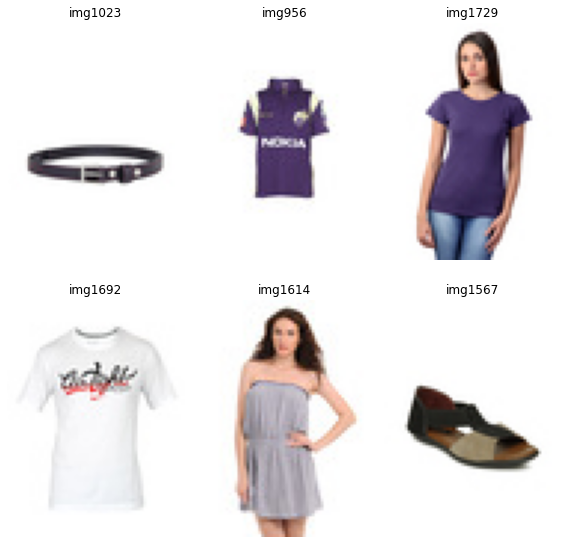

In [34]:
#title , image dictionary
figures =  {"img"+str(i): load_img(row.image) for i, row in df.sample(6).iterrows()}
plot_img(figures, 2, 3) # 2 rows , 3 columns


<AxesSubplot:>

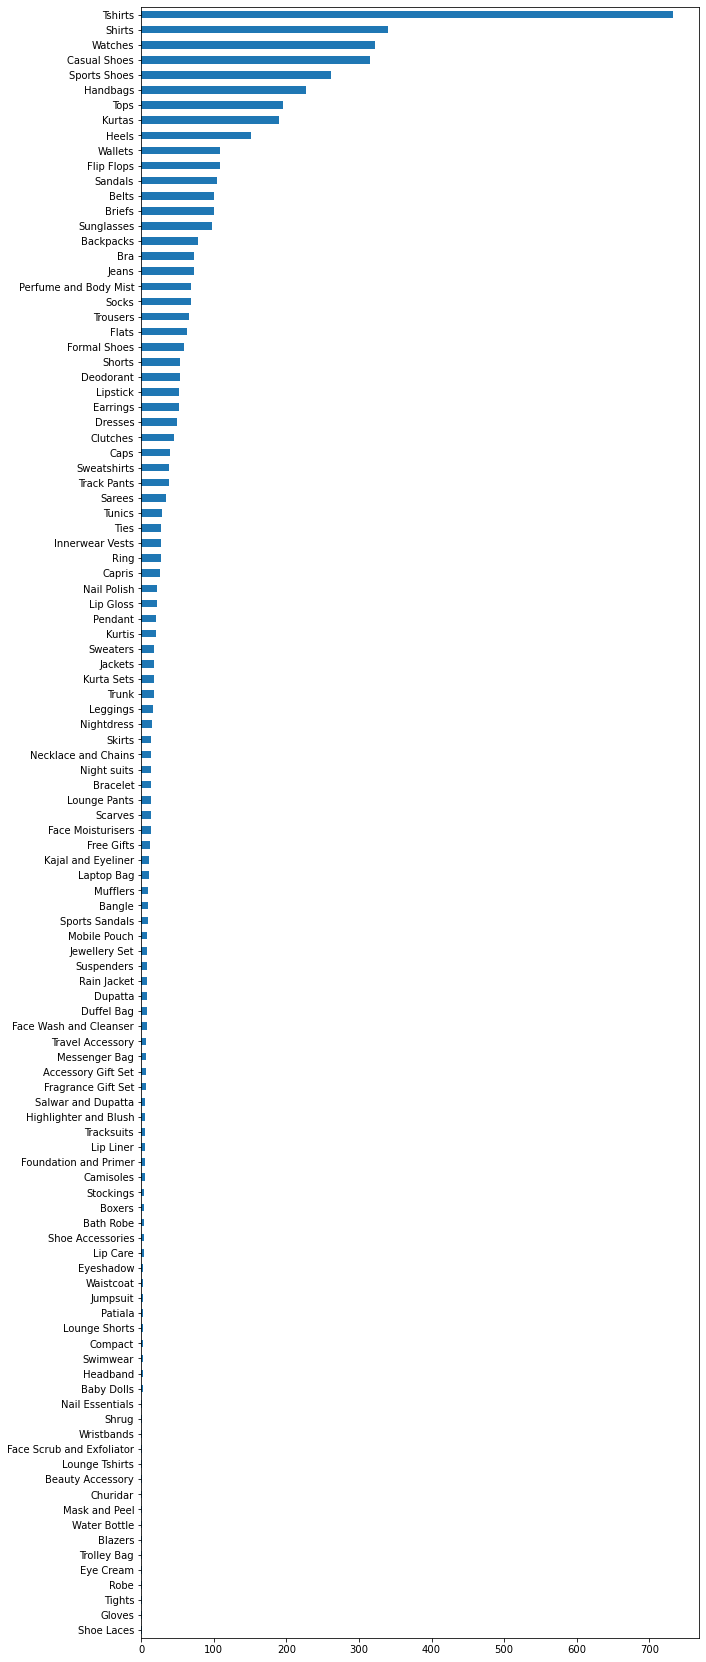

In [35]:
plt.figure(figsize=(10,30))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [36]:
img_ht, img_wt, _  = 224,224,3
base_model =  ResNet50(weights= "imagenet", include_top = False, input_shape =(img_wt, img_ht,3))
base_model.trainable = False

In [37]:
# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [38]:
def embeddings(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_wt, img_ht))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

In [39]:
# Get item embeddingd
emb = embeddings(model, df.iloc[0].image)
emb.shape

(2048,)

(80, 60, 3)
[ 2.4519038  6.7045903  0.        ...  2.1364102  2.623365  18.563387 ]


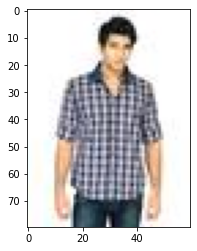

In [40]:
img_array = load_img(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [41]:
df.shape

(5000, 11)

In [43]:
# Embeddings for all the images in dataset
# Parallel apply
df_sample      = df
map_embeddings = df_sample['image'].apply(lambda img: embeddings(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)


,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,2.451904,6.704590,0.000000,1.978812,4.560532,3.994560,7.357250,8.840919,0.173763,0.545169,...,1.739151,5.757434,2.347401,23.496447,1.089248,0.000000,9.565611,2.136410,2.623365,18.563387
1,2.160765,13.004480,0.092265,6.950658,5.372179,0.000000,15.559413,2.178865,0.848539,0.146073,...,2.459617,8.469250,5.472920,8.990243,3.187701,0.256657,7.267743,0.000000,6.571843,17.669710
2,0.000000,2.099395,1.121333,5.048743,2.971104,4.301213,3.864697,1.902125,0.494969,4.596425,...,0.000000,16.961672,2.302293,1.838040,0.741313,0.000000,2.888032,2.204800,5.722475,6.089290
3,0.000000,5.336295,1.670129,11.411591,1.258608,0.000000,12.816564,7.772424,0.845027,2.947618,...,29.042675,1.647543,0.176537,0.000000,6.040600,1.806875,10.376253,0.000000,16.299788,16.499535
4,2.663742,15.295512,0.032797,2.476950,6.908784,2.586332,9.054927,7.316327,0.000000,0.000000,...,2.014318,6.502692,3.596587,19.685743,6.044681,0.000000,8.757938,2.211983,4.258551,17.862120


In [44]:
# Calculating pairwise similarity
from sklearn.metrics.pairwise import pairwise_distances

#cosine distances
cosine_similarity = 1- pairwise_distances(df_embs, metric = "cosine")
cosine_similarity[:4, :4]

array([[0.99999964, 0.63589436, 0.49575073, 0.59518987],
       [0.63589436, 1.        , 0.509784  , 0.7375228 ],
       [0.49575073, 0.509784  , 1.        , 0.471317  ],
       [0.59518987, 0.7375228 , 0.471317  , 0.9999991 ]], dtype=float32)

In [51]:
# Similar Items recommender
indices = pd.Series(range(len(df)), index=df.index)


In [66]:
def get_recommendations(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_similarity[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommendations(2993, df, top_n = 5)

(Int64Index([3349, 259, 3678, 2970, 1389], dtype='int64'),
 [0.9049992, 0.90243053, 0.8956703, 0.89079416, 0.88899016])

In [72]:
def recommender(idx_ref):
    # Recommendations
    idx_rec, idx_sim = get_recommendations(idx_ref, df, top_n = 6)

    # Plot
    plt.imshow(cv2.cvtColor(load_img(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

    # dictionary of (title, images)
    figures = {'im'+str(i): load_img(row.image) for i, row in df.loc[idx_rec].iterrows()}

    # plot of the images in a figure, with 2 rows and 3 columns
    plot_img(figures, 2, 3)
    

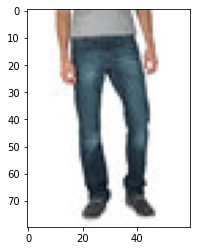

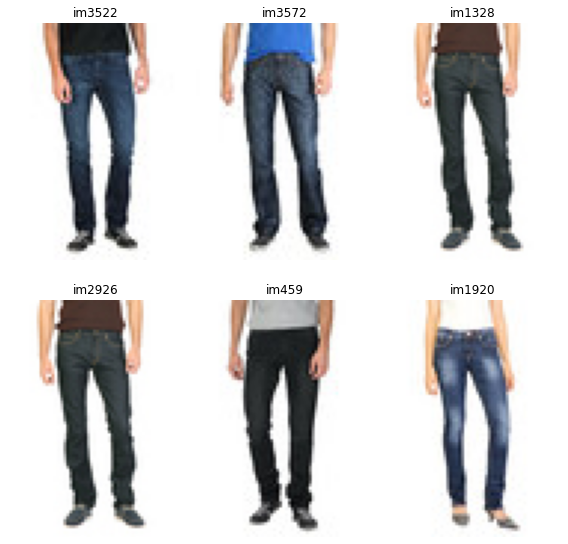

In [74]:
recommender(1)

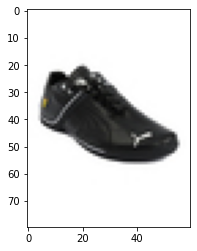

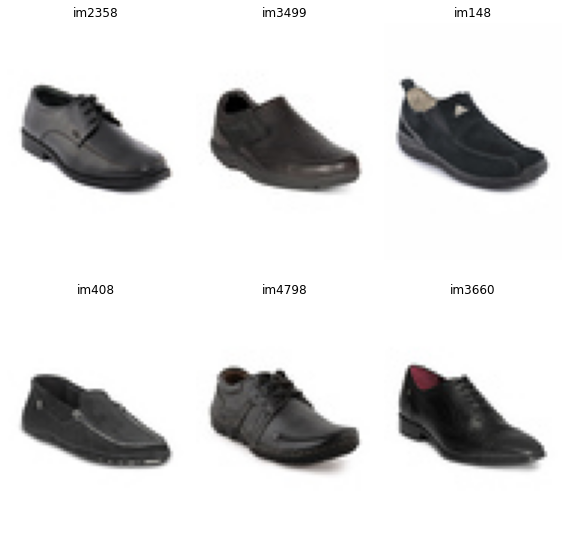

In [75]:
recommender(10)


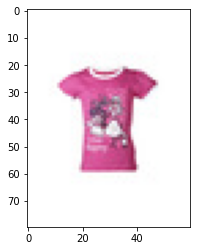

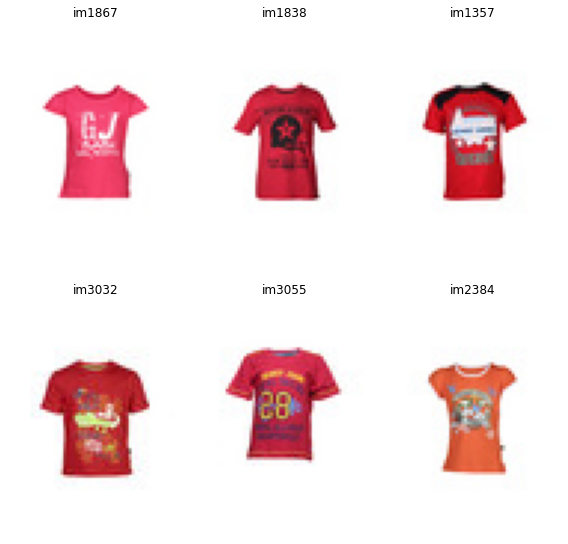

In [76]:
recommender(200)


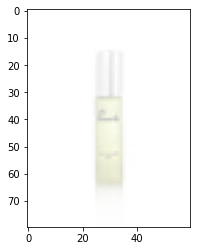

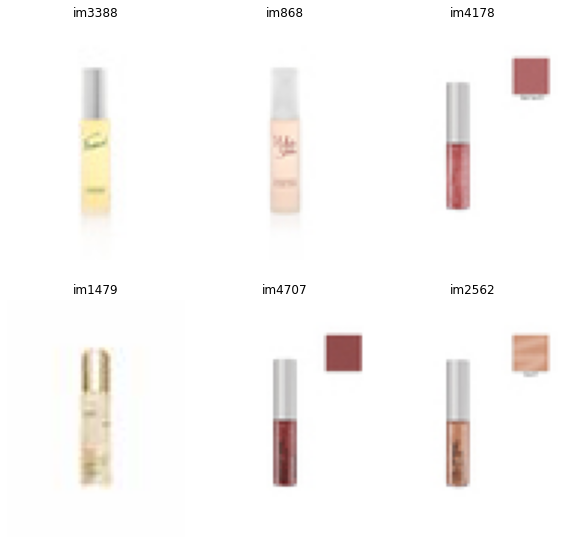

In [77]:
recommender(3001)


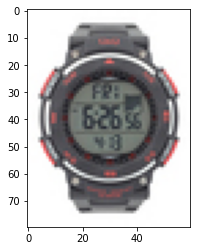

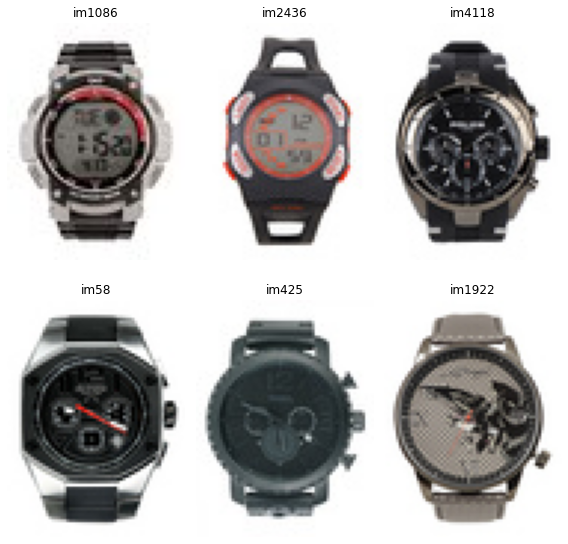

In [78]:
recommender(2876)

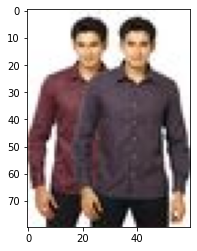

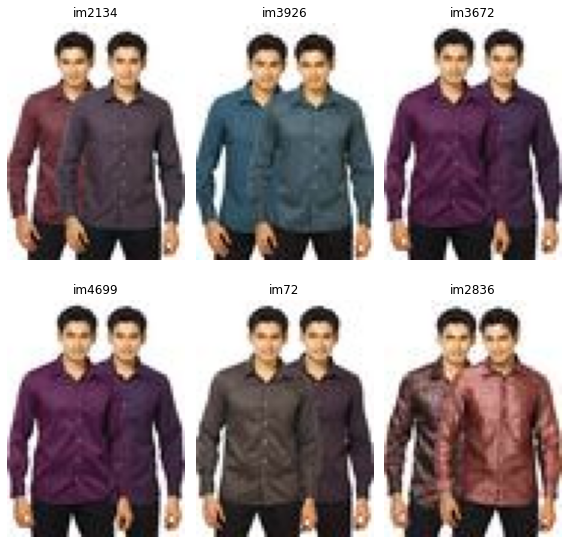

In [80]:
recommender(670)